<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_RSCCMM_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv
import openpyxl as op

In [2]:
import pandas as pd
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs)
print(test_needs)

[[1 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


In [3]:
#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u

In [4]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_AVE(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rough_u = RSCCMM(X, C, delta)
    # print(f"各クラスターの要素数: {np.sum(rough_u, axis=1)}")

    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64))
    # print(f"オーバーラップしている要素の数: {n_overlaps}")
    # print(f"オーバーラップしていない要素の数: {X.shape[0] - n_overlaps}")

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score)
    auc_sum += auc

  return auc_sum/roop

print(RSCCMM_CF_AUC_AVE(1, test_needs, X_needs, 5, -7.43))

0.8470683267991228


delta_list:  [ -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15]
C_list:  [5, 4, 3]
cluster5, delta=-5, auc=0.844364243471327
cluster5, delta=-6, auc=0.8470085221609409
cluster5, delta=-7, auc=0.8475801963585621
cluster5, delta=-8, auc=0.8460410575453519
cluster5, delta=-9, auc=0.8457559472390193
cluster5, delta=-10, auc=0.8441403913881322
cluster5, delta=-11, auc=0.8431428167984583
cluster5, delta=-12, auc=0.8428871935012294
cluster5, delta=-13, auc=0.8428408864376371
cluster5, delta=-14, auc=0.8426280400691073
cluster5, delta=-15, auc=0.8424997092830088
cluster4, delta=-5, auc=0.8442830503687955
cluster4, delta=-6, auc=0.8473281031962255
cluster4, delta=-7, auc=0.8459955811017343
cluster4, delta=-8, auc=0.8451736826367201
cluster4, delta=-9, auc=0.8443706807761313
cluster4, delta=-10, auc=0.8435531430659843
cluster4, delta=-11, auc=0.8425651206060204
cluster4, delta=-12, auc=0.8427289603960396
cluster4, delta=-13, auc=0.8427717373247392
cluster4, delta=-14, auc=0.842385499036481
cluster4, 

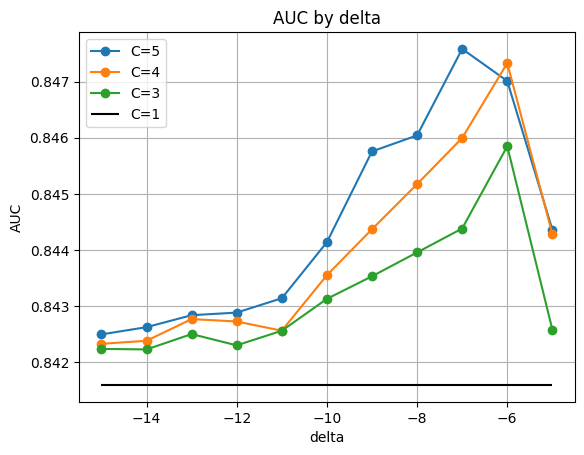

In [5]:
#deltaのリスト
name = "needs_RSCCMM_delta"
delta_list = np.arange(-5, -16, -1)
print("delta_list: ", delta_list)

#Cのリスト
C = [5, 4, 3]
print("C_list: ", C)
output = [delta_list.tolist()]
for c in C:
  #aucのリスト
  auc_list = []

  for delta in delta_list:
    auc = RSCCMM_CF_AUC_AVE(10, test_needs, X_needs, c, delta)
    print(f"cluster{c}, delta={delta}, auc={auc}")
    auc_list.append(auc)
  plt.plot(delta_list, auc_list, marker = 'o', label=f"C={c}")
  output.append(auc_list)

plt.hlines(0.8416, delta_list[0], delta_list[len(delta_list)-1], color="k", label="C=1")
plt.legend()
plt.title('AUC by delta')
plt.xlabel('delta')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

[5, 4, 3]
[ -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13. -14. -15.]
[[0.84436424 0.84700852 0.8475802  0.84604106 0.84575595 0.84414039
  0.84314282 0.84288719 0.84284089 0.84262804 0.84249971]
 [0.84428305 0.8473281  0.84599558 0.84517368 0.84437068 0.84355314
  0.84256512 0.84272896 0.84277174 0.8423855  0.84233192]
 [0.84258464 0.84584835 0.84438397 0.84395807 0.84353383 0.8431316
  0.8425645  0.84230451 0.8425049  0.84223163 0.84224097]]


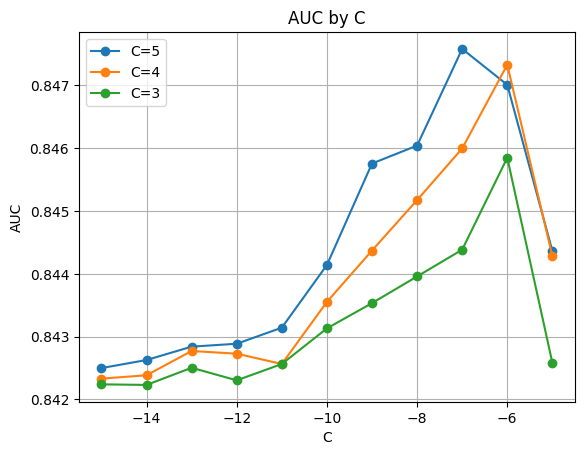

In [6]:
# csvデータから再現
name = "needs_RSCCMM_delta"
input = pd.read_csv(f'{name}.csv', header=None)

input_x_delta = input.values[0] # deltaのリスト
input_y_auc = input.values[1:, :] # aucの結果(C, input_x_delta.length)

print(C) # csvに格納すると読み込みが難しいので，再現の時は確認する
print(input_x_delta)
print(input_y_auc)

for index, c in enumerate(C):
  plt.plot(input_x_delta, input_y_auc[index], marker = 'o', label=f"C={c}")


#plt.xticks(x_C, x_C)
plt.legend()
plt.title('AUC by C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)